In [1]:
# !pip install torchviz

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
from torchviz import make_dot

In [4]:
import scanpy as sc

In [5]:
data_left=pd.read_csv('../DATA/gex_input_824_hvf.csv.gz').set_index('Unnamed: 0')
data_left.shape

(5220, 824)

In [6]:
data_right=pd.read_csv('../DATA/atac_input_3024_hvf.csv.gz').set_index('Unnamed: 0')
# data_right

In [7]:
data_left=pd.read_csv('../DATA/gex_input_824_hvf.csv.gz').set_index('Unnamed: 0')
data_left.shape
x_train_left=torch.tensor(data_left.values,dtype=torch.float32)
x_train_right=torch.tensor(data_right.values,dtype=torch.int8)

# Data Loader

In [8]:
from torch.utils.data import Dataset, DataLoader

class PairedDataset(Dataset):
    def __init__(self, data1,data2,labels):
        self.data1=data1
        self.data2=data2
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,index):
        return self.data1[index],self.data2[index],self.labels[index]
paired_dataset=PairedDataset(x_train_left,x_train_right,data_left.index)
paired_data_loader=DataLoader(dataset=paired_dataset,batch_size=256,shuffle=True)

# Model, train step & custom loss

In [9]:
class VAE(nn.Module):
    def __init__(self, left_input_dim, hidden_dim,hidden_dim2, latent_dim,right_output_dim):
        super(VAE, self).__init__()
        self.encoder1=nn.Linear(left_input_dim,hidden_dim)
        self.fc_mean=nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar=nn.Linear(hidden_dim,latent_dim)
        self.left_decoder1=nn.Linear(latent_dim,hidden_dim)
        self.left_decoder2=nn.Linear(hidden_dim,left_input_dim)
        self.right_decoder1=nn.Linear(latent_dim,hidden_dim)
        self.right_decoder2=nn.Linear(hidden_dim,hidden_dim2)
        self.right_decoder3=nn.Linear(hidden_dim2,right_output_dim)
    def encode(self,x):
        x=torch.relu(self.encoder1(x))
        mean=self.fc_mean(x)
        logvar=self.fc_logvar(x)
        return mean,logvar
    def reparameterize(self,mean,logvar):
        std=torch.exp(0.5*logvar)
        eps=torch.randn_like(std)
        return mean+std*eps
    def decode_left(self,z):
        z=torch.relu(self.left_decoder1(z))
        return self.left_decoder2(z)
    def decode_right(self,z):
        z=torch.relu(self.right_decoder1(z))
        z=torch.relu(self.right_decoder2(z))
        z=torch.sigmoid(self.right_decoder3(z))
        #floor
        return z
#         return (z>0.5).float()
    def forward(self,x):
#         mean,logvar=self.encode(x)
#         z=self.reparameterize(mean,logvar)
#         left_decoded=self.decode_left(z)
#         right_decoded=self.decode_right(z)
#         return left_decoded,right_decoded,mean,logvar
def recon_kld_loss(ytrue_left,ypred_left,ytrue_right,ypred_right,mean,logvar):
    recon_left = torch.mean((ytrue_left-ypred_left)**2)
    recon_right = torch.mean((ytrue_right-ypred_right)**2)
#     bce_loss_fn=nn.BCELoss()
#     recon_right=bce_loss_fn(ytrue_right.float(),ypred_right.float())
    kld=-.5*torch.sum(1+logvar-mean.pow(2)-logvar.exp())
    return recon_left*100+recon_right*100+kld/1000
def train_step(model,data_left,data_right,optimizer):
    optimizer.zero_grad()
    recon_left,recon_right,mean,logvar=model(data_left)
    loss=recon_kld_loss(data_left,recon_left,data_right,recon_right,mean,logvar)
    loss.backward()
    optimizer.step()
    return loss.item()

input_dim=824
hidden_dim=256
hidden_dim2=512
latent_dim=64
right_output_dim=3024
vae=VAE(input_dim,hidden_dim,hidden_dim2,latent_dim,right_output_dim)
optimizer=optim.Adam(vae.parameters())

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(4,4)

# Train Loop

In [11]:
import numpy as np
batch_size=256
epochs=10000
min_loss=np.Inf
last_loss_update=0
for epoch in range(epochs):
    for batch_data_left,batch_data_right,batch_labels in paired_data_loader:
#         batch_data_left=x_train_left[batch_start:batch_start+batch_size]
#         batch_data_right=x_train_right[batch_start:batch_start+batch_size]
        loss=train_step(vae,batch_data_left,batch_data_right,optimizer)
    if loss< min_loss:
        min_loss=loss
        last_loss_update=0
    else:
        last_loss_update+=1
    if last_loss_update>=20:
        print('No loss improvment in 10 epochs')
        break
    if epoch%10==0:
        print('Epoch: '+str(epoch), 'Loss: '+str(loss))

Epoch: 0 Loss: 101.48287963867188
Epoch: 10 Loss: 91.52993774414062
Epoch: 20 Loss: 86.06236267089844
Epoch: 30 Loss: 85.45272064208984
Epoch: 40 Loss: 85.58924865722656
Epoch: 50 Loss: 84.02493286132812
Epoch: 60 Loss: 80.50859069824219
Epoch: 70 Loss: 80.07566833496094
Epoch: 80 Loss: 80.17174530029297
Epoch: 90 Loss: 81.11774444580078
Epoch: 100 Loss: 78.6534652709961
Epoch: 110 Loss: 77.31141662597656
Epoch: 120 Loss: 75.72775268554688
Epoch: 130 Loss: 77.18118286132812
Epoch: 140 Loss: 77.18573760986328
No loss improvment in 10 epochs


In [12]:
batch_data_right.shape

torch.Size([100, 3024])

In [13]:
batch_data_left.shape

torch.Size([100, 824])

In [14]:
# for batch_data_left,batch_data_right,batch_labels in paired_dataset:
#     loss=train_step(vae,batch_data_left,batch_data_right,optimizer)
# batch_data_right.shape

In [15]:
len(paired_dataset)

5220

In [16]:
# len([_,_,_ for batch_data_left,batch_data_right,batch_labels in paired_dataset])

In [17]:
# import numpy as np
# batch_size=256
# epochs=10000
# min_loss=np.Inf
# last_loss_update=0
# for epoch in range(epochs):
#     for batch_data_left,batch_data_right,batch_labels in paired_data_loader:
#         loss=train_step(vae,batch_data_left,batch_data_right,optimizer)
#     if loss< min_loss:
#         min_loss=loss
#         last_loss_update=0
#     else:
#         last_loss_update+=1
#     if last_loss_update>=10:
#         print('No loss improvment in 10 epochs')
#         break
#     print('Epoch: '+str(epoch), 'Loss: '+str(loss))

In [18]:
print(len([batch_data_left,batch_data_right,batch_labels in paired_dataset]))

3


# Achieving lower loss without data loader, overfitting?

In [19]:
import numpy as np
batch_size=256
epochs=10000
min_loss=np.Inf
last_loss_update=0
for epoch in range(epochs):
    for batch_start in range(0,len(x_train_left),batch_size):
        batch_data_left=x_train_left[batch_start:batch_start+batch_size]
        batch_data_right=x_train_right[batch_start:batch_start+batch_size]
        loss=train_step(vae,batch_data_left,batch_data_right,optimizer)
    if loss< min_loss:
        min_loss=loss
        last_loss_update=0
    else:
        last_loss_update+=1
    if last_loss_update>=10:
        print('No loss improvment in 10 epochs')
        break
    if epoch%10==0:
        print('Epoch: '+str(epoch), 'Loss: '+str(loss))

Epoch: 0 Loss: 77.11071014404297
Epoch: 10 Loss: 72.58258056640625
Epoch: 20 Loss: 69.4390869140625
Epoch: 30 Loss: 67.18199157714844
Epoch: 40 Loss: 65.04704284667969
Epoch: 50 Loss: 63.22325897216797
Epoch: 60 Loss: 61.559444427490234
Epoch: 70 Loss: 60.59970474243164
Epoch: 80 Loss: 58.957847595214844
Epoch: 90 Loss: 57.65150451660156
Epoch: 100 Loss: 56.93135070800781
Epoch: 110 Loss: 56.02375030517578
Epoch: 120 Loss: 55.043643951416016
Epoch: 130 Loss: 54.456947326660156
Epoch: 140 Loss: 53.743324279785156
Epoch: 150 Loss: 53.181705474853516
Epoch: 160 Loss: 52.739994049072266
Epoch: 170 Loss: 52.18866729736328
Epoch: 180 Loss: 51.54743194580078
Epoch: 190 Loss: 51.160362243652344
Epoch: 200 Loss: 50.865230560302734
Epoch: 210 Loss: 50.40109634399414
Epoch: 220 Loss: 50.13289260864258
Epoch: 230 Loss: 49.404605865478516
Epoch: 240 Loss: 49.12060546875
Epoch: 250 Loss: 48.98462677001953
Epoch: 260 Loss: 48.83904266357422
Epoch: 270 Loss: 48.35938262939453
Epoch: 280 Loss: 48.10277

In [20]:
recon_gex,generated_sample,_,_=vae(x_train_left)
output=vae(x_train_left)

In [21]:
dot = make_dot(output, params=dict(vae.named_parameters()))
dot.render("model_graph", format="png")

'model_graph.png'

# Model Diagram

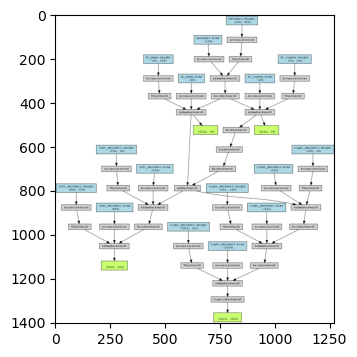

In [22]:
import matplotlib.pyplot as plt
from PIL import Image

# Open and display the saved image
img = Image.open("model_graph.png")
plt.imshow(img)
plt.show()

In [23]:
recon_gex=recon_gex.detach().numpy()

In [24]:
from scanpy import AnnData

In [25]:
adata=AnnData(data_left)
gdata=AnnData(pd.DataFrame(recon_gex))
gdata.obs.index=adata.obs.index
gdata.var.index=adata.var.index

# Original and reconstructed GEX data

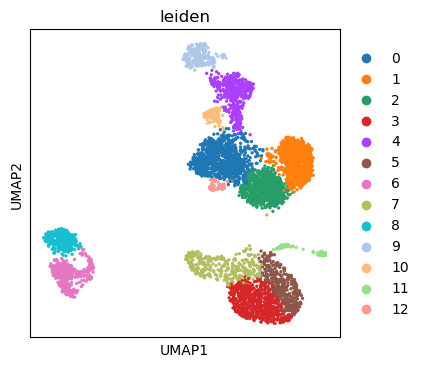

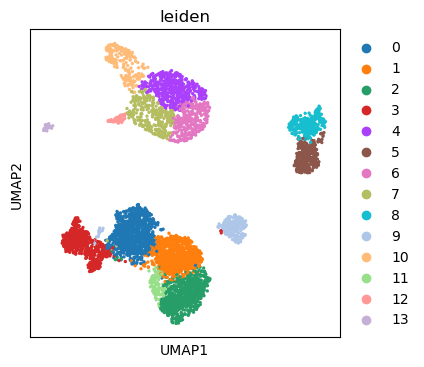

In [26]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='leiden')
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
sc.pl.umap(gdata,color='leiden')

In [27]:
cdata=adata.concatenate(gdata)

# Integrated original and recon data (no batch correction)

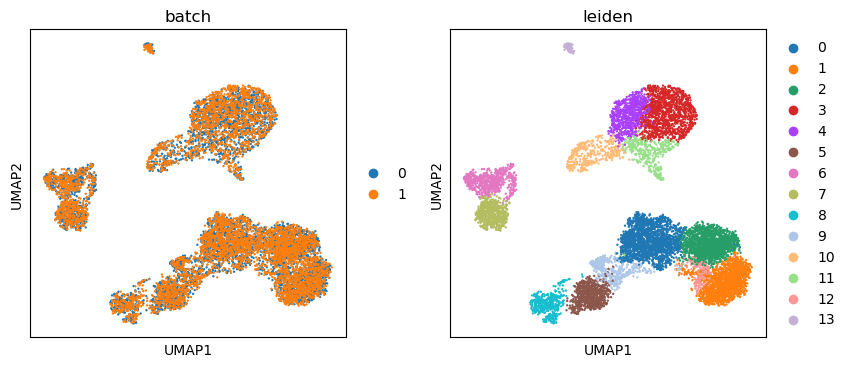

In [28]:
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden'])

# GEX integrated and recon data (with batch correction)

2023-11-30 09:50:45,383 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-11-30 09:50:49,217 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-11-30 09:50:49,268 - harmonypy - INFO - Iteration 1 of 20
2023-11-30 09:50:52,934 - harmonypy - INFO - Iteration 2 of 20
2023-11-30 09:50:56,622 - harmonypy - INFO - Iteration 3 of 20
2023-11-30 09:50:59,783 - harmonypy - INFO - Iteration 4 of 20
2023-11-30 09:51:01,045 - harmonypy - INFO - Iteration 5 of 20
2023-11-30 09:51:02,336 - harmonypy - INFO - Iteration 6 of 20
2023-11-30 09:51:03,944 - harmonypy - INFO - Converged after 6 iterations


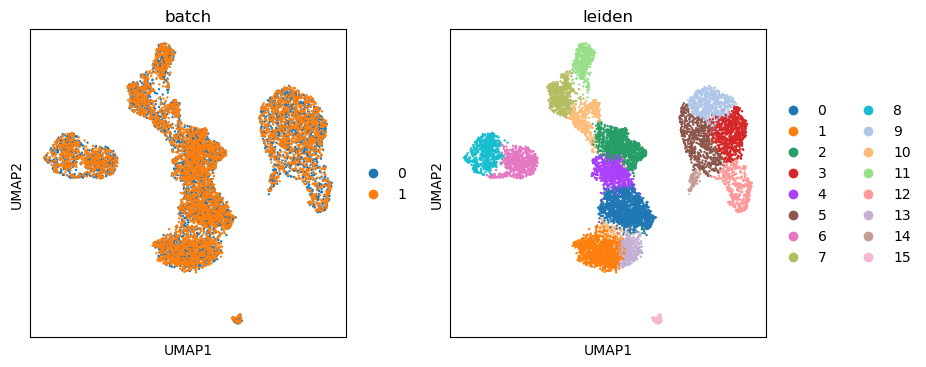

In [30]:
sc.external.pp.harmony_integrate(cdata, 'batch',max_iter_harmony=20)
sc.pp.neighbors(cdata,n_pcs=20,n_neighbors=20,use_rep='X_pca_harmony')
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden'])

# Original ATAC, reconstructed ATAC, & integrated ATAC (with and without BC)

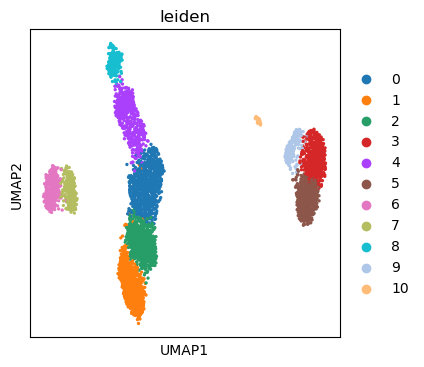

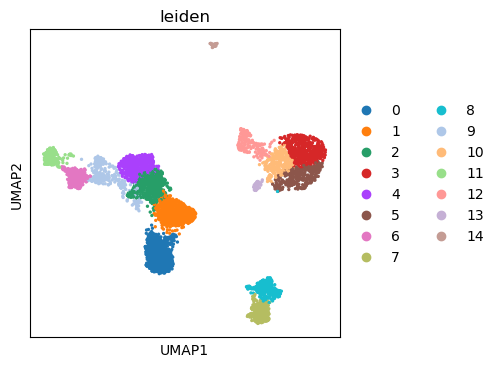

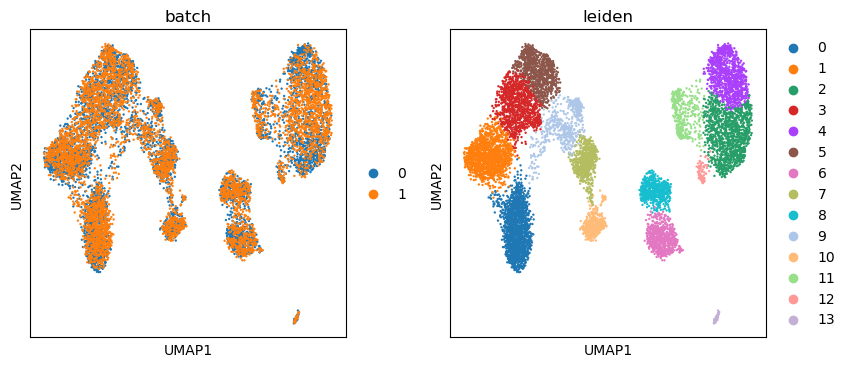

2023-11-30 09:52:25,061 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-11-30 09:52:29,064 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-11-30 09:52:29,114 - harmonypy - INFO - Iteration 1 of 20
2023-11-30 09:52:32,989 - harmonypy - INFO - Iteration 2 of 20
2023-11-30 09:52:36,706 - harmonypy - INFO - Iteration 3 of 20
2023-11-30 09:52:40,571 - harmonypy - INFO - Converged after 3 iterations


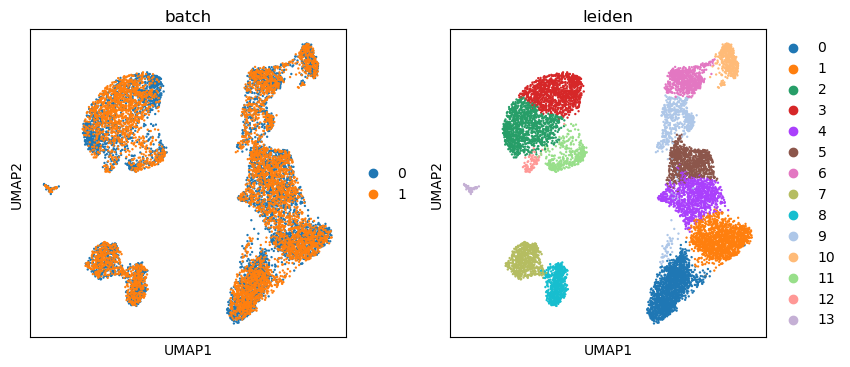

In [31]:
adata=AnnData(data_right)
gdata=AnnData(pd.DataFrame(generated_sample.detach().numpy()))
gdata.obs.index=adata.obs.index
gdata.var.index=adata.var.index
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='leiden')
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
sc.pl.umap(gdata,color='leiden')
cdata=adata.concatenate(gdata)
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden'])
sc.external.pp.harmony_integrate(cdata, 'batch',max_iter_harmony=20)
sc.pp.neighbors(cdata,n_pcs=20,n_neighbors=20,use_rep='X_pca_harmony')
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden'])